In [1]:
from zss import simple_distance, Node
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_json_in_dict(path):
    ''' 
    Loads ordered dictionnary of bounds per pages and per coordinates from a json file
    :param string path: where all data of libretto is stored, as explained above
    '''
    with open(path) as json_file: 
        return json.load(json_file)

In [3]:
def create_tree(libretto, gt = False):
    ''' 
    Creates a tree structure of the desired libretto for the computation of the later similarity distance
    :param string libretto: the name of the libretto we want to process
    :param boolean gt, default=False: if gt==True, we select the ground_truth dataset, else we select the predicted one.
    '''
    # Load data
    data = ""
    if gt:
        data = load_json_in_dict("./data/"+libretto+"/3_Network/network_truth.json")
    else:
        data = load_json_in_dict("./data/"+libretto+"/3_Network/network.json")
    
    # Create tree root
    tree = Node(libretto)
    # Create nodes
    for act in data.keys():
        node_act = Node(act)
        for scene in data[act].keys():
            node_scene = Node(scene)
            for char in data[act][scene].keys():
                # Create leaves
                for i in range(data[act][scene][char]):
                    node_scene.addkid(Node(char))
            node_act.addkid(node_scene)
        tree.addkid(node_act)
    return (tree)

In [4]:
# Compute the similarity distance from the gorund-truth and the predicted libretto
libretto = 'Gli'

def compute_similarity(libretto):
    ''' 
    Computes the similarity distance of one libretto, based on its ground-truth and predicted data
    :param string libretto: the name of the libretto we want to process
    '''
    # Create the tree from the ground-truth data
    gt_tree = create_tree(libretto, gt = True)
    # Create the tree from the predicted data
    predicted_tree = create_tree(libretto, gt = False)
    return simple_distance(gt_tree, predicted_tree)

In [5]:
compute_similarity(libretto)

258.0

In [6]:
def create_subtree(act, scene, data):
    ''' 
    Creates a sub-tree structure of the desired libretto for the computation of the later similarity distance.
    It creates a sub-tree where the root is a predefined scene in a predefined act.
    :param string act: the act of the libretto we want to process
    :param string scene: the scene of the libretto we want to process
    :param dict data: the json data file of the libretto we want to process
    '''
    # Create root
    node_scene = Node(scene)
    for char in data[act][scene].keys():
        # Create leaves
        for i in range(data[act][scene][char]):
            node_scene.addkid(Node(char))
    return node_scene

In [7]:
def distance_scenes(data_gt, data_predict, act, scene):
    ''' 
    Compute the similarity distance for the sub-tree structures of the desired libretto.
    The sub-tree has as the root a predefined scene from a predefined act.
    :param zss.Node data_gt: the ground-truth tree
    :param zss.Node data_predict: the predicted tree
    :param string act: the act of the libretto we want to process
    :param string scene: the scene of the libretto we want to process
    '''
    # Create sub-trees
    node_scene_gt = create_subtree(act, scene, data_gt)
    node_scene_predict = create_subtree(act, scene, data_predict)
    
    dist = simple_distance(node_scene_gt, node_scene_predict) 
    return dist

In [8]:
def plot_distances(libretto, data_gt, data_predict): 
    ''' 
    Plot the similarity distance for the sub-tree structures of the desired libretto.
    This will permit to get the number of errors encountered per scene and per act
    :param string libretto: the name of the libretto we want to process
    :param zss.Node data_gt: the ground-truth tree
    :param zss.Node data_predict: the predicted tree
    '''
    dist_act = list()
    #Compute distance plot only for acts in two subtrees
    for act in data_gt.keys():
        if (act in data_predict.keys()):
            dist_scene = list()
            #Compute distance plot only for scenes in two subtrees
            for scene in data_gt[act].keys():
                if (scene in data_predict[act].keys()):
                    dist_scene.append(distance_scenes(data_gt, data_predict, act, scene))
            dist_act.append(dist_scene)
            
    # Set style
    sns.set_style("darkgrid")

    # color palette
    colors = ['tab:orange', 'tab:blue', 'tab:red', 'tab:green']
    
    # Plot
    df = pd.DataFrame(dist_act).T.reset_index()
    for col in range(1, df.shape[1]):
        df.rename(columns={col-1: str(col)}, inplace=True)
    for i, col in enumerate(df.columns[1:]):
        sns.scatterplot(data=df, x="index", y=col, color=colors[i])
        sns.lineplot(data=df, x="index", y=col, color=colors[i])
        
    # Add Labels and legend
    plt.xlabel(f"Scene")
    plt.ylabel(f"Number of errors")
    plt.title(f'Error plot of "{libretto}" libretto');
    plt.legend(bbox_to_anchor=(0., -0.35, 1., .102), loc='lower center',
               ncol=2, mode="expand", borderaxespad=0., 
               labels = ["Act " + str(i) for i in range(1, df.shape[1])])

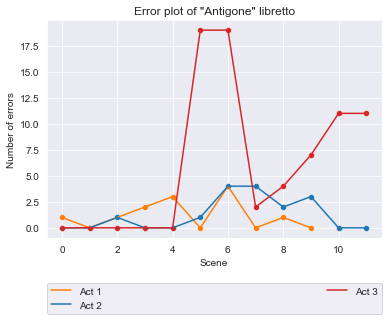

In [9]:
# Load data
libretto = "Antigone"
data_gt = load_json_in_dict("./data/"+libretto+"/3_Network/network_truth.json")
data_predict = load_json_in_dict("./data/"+libretto+"/3_Network/network.json")

# Error plot of chosen libretto
plot_distances(libretto, data_gt, data_predict)